<a href="https://www.kaggle.com/code/iremakdogan/s7l57-ann-with-breadth-or-depth?scriptVersionId=187773806" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
# Import and process the data
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from IPython import display
display.set_matplotlib_formats('svg')

I am following the Deep Learning course of Mike X Cohen on Udemy, Lecture 57 Exercise on how  depth versus breadth affect the ANN performance

So the breadth of a model is the number of units it has in a particular layer. And the depth is the number of hidden layers. So the number of layers between input and output.

# Create Data

In [2]:
iris = sns.load_dataset('iris')
data = torch.tensor(iris[iris.columns[0:4]].values).float()
# transform output labels to number
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species=='setosa'] = 0
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

# Create Model

In [3]:
# create a class for the model
# we CANNOT do this dynamic layers and units with nn.Sequential

class ANNiris(nn.Module):
  # only definitions, no data here
  def __init__(self, nUnits, nLayers):
    super().__init__()

    # create dictionary to store all the layers
    # this is NOT like normal python dictionary, this is speacially designed for storing LAYERS
    self.layers = nn.ModuleDict() # like how PyTorch define in itself
    self.nLayers = nLayers

    ### input layers
    # iris data have 4 features - we can make it variable also
    self.layers['input'] = nn.Linear(4,nUnits)

    ### hidden layers
    for i in range(nLayers):
      self.layers[f'hidden{i}'] = nn.Linear(nUnits, nUnits)

    ### output layer
    self.layers['output'] = nn.Linear(nUnits, 3)

  def forward(self,x):
    # input layer
    x = self.layers['input'](x)

    # hidden layers
    for i in range(self.nLayers):
      x = F.relu( self.layers[f'hidden{i}'](x) )

    # output layer
    x = self.layers['output'](x)
    # dont we need Softmax?

    return x

In [4]:
# generate the instance of the model
nUnitsPerLayer = 12
nLayer = 4

net = ANNiris(nUnitsPerLayer, nLayer)

net

ANNiris(
  (layers): ModuleDict(
    (input): Linear(in_features=4, out_features=12, bias=True)
    (hidden0): Linear(in_features=12, out_features=12, bias=True)
    (hidden1): Linear(in_features=12, out_features=12, bias=True)
    (hidden2): Linear(in_features=12, out_features=12, bias=True)
    (hidden3): Linear(in_features=12, out_features=12, bias=True)
    (output): Linear(in_features=12, out_features=3, bias=True)
  )
)

In [5]:
### ALWAYS QUICKLY TEST THE MODEL THROUGH RUNNING SOME NUMBERS
# This way you can ensure that the architecture is internally consistent
# we will see the erros when put data in the model

# 10 samples, 4 dimensions bec input dim is 4
tmpx = torch.randn(10,4)
# run it through the DL
y = net(tmpx)

# examine the shape of the output
print(y.shape), print(' ')
# and output itself
print(y)

torch.Size([10, 3])
 
tensor([[ 0.4611, -0.0947,  0.1124],
        [ 0.4806, -0.0967,  0.1092],
        [ 0.4701, -0.0743,  0.1272],
        [ 0.4711, -0.0739,  0.1282],
        [ 0.4691, -0.0745,  0.1267],
        [ 0.4690, -0.0744,  0.1268],
        [ 0.4690, -0.0738,  0.1271],
        [ 0.4644, -0.0831,  0.1192],
        [ 0.4711, -0.0752,  0.1266],
        [ 0.4644, -0.0731,  0.1280]], grad_fn=<AddmmBackward0>)


# Train the Model

In [6]:
# Train the model
epochnum = 1000

def trainModel(theModel):

  # define loss function and optimizer
  lossfun = nn.CrossEntropyLoss() # since the output dim is 3
  optimizer = torch.optim.SGD(theModel.parameters(), lr=.01)

  # loop over iterations
  for i in range(epochnum):
    # forward prop
    yHat = theModel(data)

    # compute loss
    loss = lossfun(yHat, labels)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # final pass
  predictions = theModel(data)
  predLabels = (torch.argmax(predictions, axis=1) == labels).float()
  acc = 100*torch.mean(predLabels)

  # total number of trainable parameters in the model
  nParams = sum(p.numel() for p in theModel.parameters() if p.requires_grad)

  return acc, nParams

In [7]:
# test the function
acc = trainModel(net)

# check the output
acc # tuple containing (accuracy,params)

(tensor(66.6667), 723)

# Now the Experiment

In [8]:
# Takes time! 

# define the model parameters
numlayers = range(1,6)
numunits = np.arange(4,101,3)

# initialize output matrices
accuracies  = np.zeros((len(numunits), len(numlayers))) # need to take size as tuple
totalparams = np.zeros((len(numunits), len(numlayers)))

# number of training epochs
numepochs = 500

# run the experiment
for unitidx in range(len(numunits)):
  for layeridx in range(len(numlayers)):
    # create a fresh model instance in everytime
    net = ANNiris(numlayers[layeridx], numunits[unitidx])

    # train the model and store the outputs
    acc, nParams = trainModel(net)
    accuracies[unitidx, layeridx] = acc
    totalparams[unitidx, layeridx] = nParams

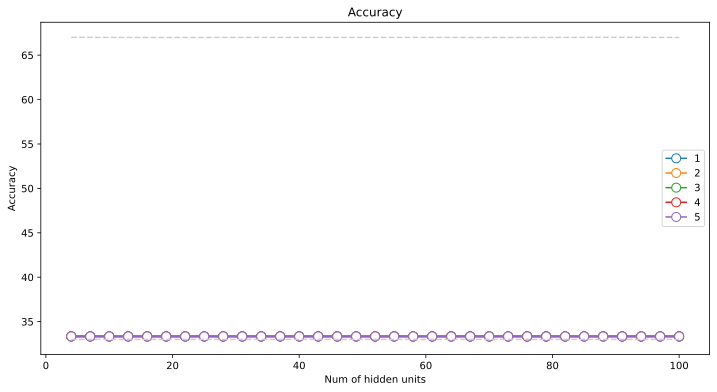

In [9]:
# plot the results

fig, ax = plt.subplots(1,figsize=(12,6))
ax.plot(numunits, accuracies, 'o-', markerfacecolor='w', markersize=9)
ax.plot(numunits[[0,-1]],[33,33],'--',color=[.8,.8,.8])
ax.plot(numunits[[0,-1]],[67,67],'--',color=[.8,.8,.8])
ax.legend(numlayers)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Num of hidden units')
ax.set_title('Accuracy')
plt.show()

# **Lets find the correlation between number of parameters and accuracy**

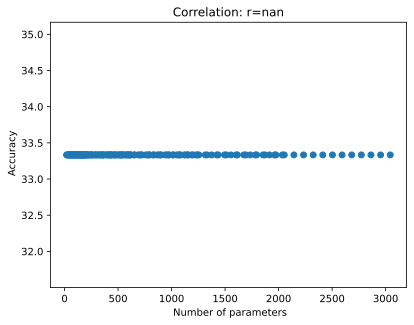

In [10]:
# vetorize for convenience
x = totalparams.flatten()
y = accuracies.flatten()

# correlation between them
r = np.corrcoef(x,y)[0,1]

# scatter plot
plt.plot(x,y,'o')
plt.xlabel(' Number of parameters')
plt.ylabel(' Accuracy')
plt.title( 'Correlation: r=' + str(np.round(r,3)))
plt.show()

# Zero correlation btw accuracy and number of parameters
there is no correlation btw the number of parameters and the accuracy.
* Architecture is important
* Other metaparameters of the model is important
* The optimizer is really important